In [33]:
import json
import matplotlib.pyplot as plt
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
MIN_FREQ, MAX_FREQ = 2000, 4000
MAX_VISUAL_FREQ = 5000
SAMPLE_RATE = 150000
NYQUIST = SAMPLE_RATE / 2 + 1

spectrogram = json.load(open("../data/test_audio/robocup.json", "r"))
min_i = int(MIN_FREQ * len(spectrogram[0]["powers"]) / NYQUIST)
max_i = min_i + 21 #int(MAX_FREQ * len(spectrogram[0]["powers"]) / NYQUIST)

model_input = np.array([step["powers"][min_i:max_i+1] for step in spectrogram]).astype(np.float32).T

max_i = int(MAX_VISUAL_FREQ * len(spectrogram[0]["powers"]) / NYQUIST)
spectrogram = np.array([step["powers"][:max_i+1] for step in spectrogram]).astype(np.float32).T

In [35]:
class TwoLayerIntegrated(nn.Module):
    def __init__(self, input_dim):
        super(TwoLayerIntegrated, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.sigmoid(self.layer2(x))
        
        return x

model = TwoLayerIntegrated(model_input.shape[0])
model.load_state_dict(torch.load("../models/whistle_detection2.pth"))
model.eval()

TwoLayerIntegrated(
  (layer1): Linear(in_features=22, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=1, bias=True)
)

In [36]:
THRESHOLD = 0.01

preds = model(torch.tensor(model_input.T)).cpu().detach().numpy()

In [37]:
detects = np.where(preds >= THRESHOLD)[0]

# delete contigues entries
detects = [detects[0]] + [
    detects[i] for i in range(1, len(detects)) if detects[i] - 1 != detects[i-1]
]
detects

[136,
 142,
 153,
 161,
 168,
 182,
 184,
 431,
 551,
 825,
 868,
 893,
 910,
 976,
 981,
 1002,
 1004,
 1013,
 1074,
 1132,
 1138,
 1212,
 1214,
 1382,
 1732,
 1745,
 1792,
 1801,
 1821,
 1824,
 1936,
 1997,
 2040,
 2043,
 2051,
 2206,
 2434,
 2449,
 2468,
 2523,
 2526,
 2528,
 2565,
 3231,
 3392,
 3394,
 3408,
 3484,
 3500,
 3532,
 3576,
 3599,
 3613,
 3622,
 3637,
 3691,
 3725,
 3736,
 3746,
 3818,
 3824,
 3865,
 3877,
 3891,
 3924,
 3935,
 3938,
 3962,
 3985,
 3994,
 4027,
 4168,
 4182,
 4264,
 4315,
 4332,
 4490,
 4496,
 4619,
 4632,
 4742,
 5023,
 5059,
 5130,
 5140,
 5147,
 5161,
 5207,
 5226,
 5247,
 5253,
 5256,
 5308,
 5310,
 5342,
 5344,
 5357,
 5382,
 5417,
 5492,
 5496,
 5585,
 5588,
 5602,
 5607,
 5620,
 5623,
 5629,
 5633,
 5646,
 5650,
 5654,
 5668,
 5673,
 5684,
 5712,
 5721,
 5727,
 5731,
 5736,
 5743,
 5751,
 5762,
 5770,
 5779,
 5782,
 5785,
 5791,
 5794,
 5800,
 5812,
 5828,
 5830,
 5832,
 5845,
 5859,
 5929,
 5939,
 5952,
 5980,
 6010,
 6039,
 6046,
 6063,
 6074,


In [38]:
preds.min()

2.6170773e-13

In [39]:
model_input.shape

(22, 45025)

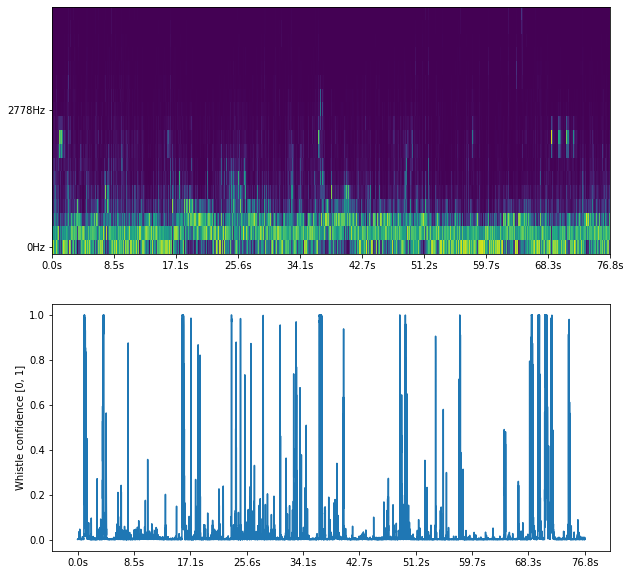

In [40]:
LAG = 256

fig, (ax0, ax1) = plt.subplots(2, 1)

fig.set_size_inches(10, 10)

# * plot spectrogram *
img = spectrogram
ax0.imshow(img / np.sum(img**2, axis=0)**0.5, cmap="viridis", interpolation="none", aspect="auto", origin="lower")

xticks = np.arange(0, img.shape[1], 5000)
xticklabels = [f"{t * LAG / SAMPLE_RATE:.1f}s" for t in xticks]
ax0.set_xticks(xticks, xticklabels)

yticks = np.arange(0, img.shape[0], 10)
yticklabels = [f"{i / img.shape[0] * MAX_VISUAL_FREQ:.0f}Hz" for i in yticks]
ax0.set_yticks(yticks, yticklabels)

# * plot model predictions *
x = list(range(model_input.shape[1]))
ax1.plot(x, preds)
ax1.set_xticks(xticks, xticklabels)
ax1.set_ylabel("Whistle confidence [0, 1]")

# plot detections
for i in detects:
    #ax1.axvline(x[i], c="red", linestyle="dashed")
    pass

plt.show()